In [14]:
# Set local python and nltk paths
import sys
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/IPython/extensions')
sys.path
import nltk
nltk.data.path = ['/vol/medic02/users/ag6516/nltk_data']

# 1. Report Pre-processing

In [16]:
dir = ('/vol/medic02/users/ag6516/x_ray_fracture_localisation/')
# dir = ('/Users/Aydan/PhD/x_ray_fracture_localisation/')
df = pd.read_csv(dir + 'cleaned_reports_edited.csv')

In [63]:
%matplotlib inline

import os
import csv
import json
import pickle
import pandas as pd

import sklearn
from sklearn import model_selection
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
import random
random.seed(123)
np.random.seed(123)

import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Set THEANO_FLAGS='device=cuda0,floatX=float32' to run notebook on gpu
import lasagne
from lasagne.utils import floatX
import theano
import theano.tensor as T
from collections import Counter
from lasagne.utils import floatX

import googlenet

from read_data import read_csv_into_df
from vis_utils import kmeans_clustering, plot_pca, visualise_word_clusters2, kmeans_silhouette
from vis_utils import save_clusters_to_json, load_clusters_from_json

In [54]:
reports = []
reports_tok = []
labels = []
words = []
report_lenghts = []

for i, row in df.iterrows():
    report = row['Report text'].decode('utf-8').lower()
    
    # Remove markdown
    for char in ['\n', '\b']:
        report = report.replace(char, '')
    
    # Replace unnecessary punctuation 
    for char in ['~', '"']:
        report = report.replace(char, '')
        
    for char in ['!', '?', ';', ':', '.']:
        report = report.replace(char, ' . ')
    
    for char in ['(', ')', ',', '/']:
        report = report.replace(char, ' , ')
        
    # filter out 'comparison' + dates
    #report = re.sub('( compar.*?\d{4})', '', report)
    report = re.sub('(compar.*?\d{4})', '', report)
    report = re.sub('(compar.*?\d{2})', '', report)
    report = re.sub('(xr knee both)', '', report)
    report = re.sub('(xr knee)', '', report)
    report = re.sub('(previous.*comparison)', '', report)
        
    # Tokenize
    report_tok = word_tokenize(report)
    report_length = len(report_tok)
    
    # Remove stopwords
    filtered_report_tok = [word for word in report_tok if word not in stopwords.words('english')]
    filtered_report = ' '.join(filtered_report_tok)
    
    reports.append(filtered_report)
    reports_tok.append(filtered_report_tok)
    labels.append(row['Accession'])
    [words.append(word) for word in filtered_report_tok]
    report_lenghts.append(report_length)

print 'Vocab length: ', len(sorted(set(words)))
print 'Avg no. of appearances: ', len(words)/len(sorted(set(words)))
fdist_all = nltk.FreqDist(words)
freqs = [freq for _, freq in fdist_all.most_common()]
print 'STD: ', np.std(freqs)
#print fdist_all.hapaxes()
print 'Number of reports: ', len(reports)
print 'Average length of report: ', float(sum(report_lenghts))/float(len(reports))
print ''
df['Cleaned report'] = reports
print df.count()

Vocab length:  1737
Avg no. of appearances:  43
STD:  349.410439207
Number of reports:  3561
Average length of report:  30.8393709632

Unnamed: 0          3561
Accession           3561
Clinical history    2221
Comment             2390
Report text         3561
Cleaned report      3561
dtype: int64


## 1.2 Extract CNN image embeddings

In [7]:
# print(theano.config)

Build the model and select layers we need - the features are taken from the final network layer, before the softmax nonlinearity.


In [8]:
cnn_layers = googlenet.build_model()
cnn_input_var = cnn_layers['input'].input_var
cnn_feature_layer = cnn_layers['loss3/classifier']
cnn_output_layer = cnn_layers['prob']

get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

Load the pretrained weights into the network


In [9]:
model_param_values = pickle.load(open('blvc_googlenet.pkl'))['param values']
lasagne.layers.set_all_param_values(cnn_output_layer, model_param_values)

The images need some preprocessing before they can be fed to the CNN


In [10]:
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (224, w*224/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*224/w, 224), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

In [11]:
# convert png to jpg
# import os
# from PIL import Image

# for folder in os.listdir(dir+'data/Images'):
#     for image in os.listdir(dir+'data/Images/' + str(folder)):
#         print image
#         try:
#             im = Image.open(dir+'data/Images/' + str(folder) + '/' + str(image))
#             rgb_im = im.convert('RGB')
#             new_fn = os.path.splitext(image)[0] + '.jpg'
#             print new_fn
#             rgb_im.save(dir+'data/Images/' + str(folder) + '/' + new_fn)
#         except IOError, e:
#             print "error opening file :: %s : %s" % (dir+'data/Images/' + str(folder) + '/' + str(image), e)
#             continue


# print len(patient_ids)

Sample exams. Each exam may contain more than one x-ray image, taken from different views.

330
RJ109691971
377    No previous radiograph is available for comparison.\n\nThere is bilateral severe tricompartmental degenerative changes with complete loss of the joint space in the medial knee compartment, osteophytosis and subchondral sclerosis.\nNo acute bone injury.
Name: Report text, dtype: object


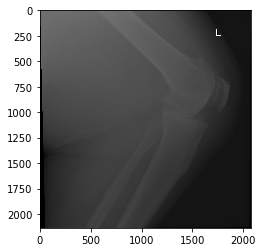

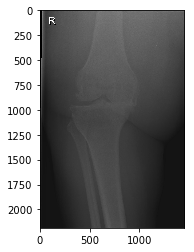

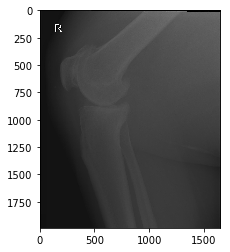

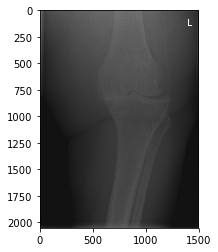

In [18]:
pd.options.display.max_colwidth = 4000

patient_ids = []
for folder in os.listdir(dir+'data/Images'):
    patient_ids.append(str(folder))

print len(patient_ids)
sample_patient = random.choice(patient_ids)
print sample_patient

report_sample = df.loc[df['Accession'] == sample_patient]['Report text']
print report_sample

sample_exam = []
for image in os.listdir(dir + 'data/Images/' + str(sample_patient)):
    if image.endswith('.jpg'):
        im = plt.imread(dir + 'data/Images/' + str(sample_patient) + '/' + str(image))
        sample_exam.append(im)
        plt.figure()
        plt.imshow(im)
        im.shape

In [28]:
prepd_images = []
for im in sample_exam:
    rawim, cnn_im = prep_image(im)
    prepd_images.append((rawim, cnn_im))

/vol/medic02/users/ag6516/miniconda/envs/TheanoLasagne/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [29]:
CLASSES = pickle.load(open('blvc_googlenet.pkl'))['synset words']
for im in prepd_images:
    p = get_cnn_features(im[1])
    print(CLASSES[p.argmax()])

Band Aid
shower curtain
seat belt, seatbelt
brassiere, bra, bandeau


Extract a sample of images, assign the corresponding report and a view label for each image

In [56]:
sample_images = []
for pid in patient_ids:
    for image in os.listdir(dir + 'data/Images/' + str(pid)):
        if image.endswith('.jpg'):
            if '_' in image:
                imid = os.path.splitext(image)[0]
                leg = imid.split('_')[-1]
                view = imid.split('_')[-2]
            
                item = {}
            
                item['imid'] = imid.split('_')[0]
                item['patient id'] = pid
                item['report'] = reports[labels.index(pid)]
                item['tokens'] = reports_tok[labels.index(pid)]
                item['leg'] = leg
                item['view'] = view
                sample_images.append(item)

import json
with open('sample_images.json', 'w') as fp:
    json.dump(sample_images, fp)

Extract CNN features for each image

In [58]:
for item in sample_images:
    path = dir + 'data/Images/' + str(item['patient id']) + '/' + item['imid'] + '_' + item['view'] + '_' + item['leg'] + '.jpg'
    #try:
    im = plt.imread(path)
    _, cnn_input = prep_image(im)
    #except IOError:
    #        continue
    features = get_cnn_features(cnn_input)
    item['cnn features'] = features

Train/test split

In [79]:
train1, test = model_selection.train_test_split(sample_images, train_size=0.8, random_state=42)
train, val = model_selection.train_test_split(train1, train_size=0.8, random_state=42)

for item in train:
    item['split'] = 'train'
    
for item in train:
    item['split'] = 'val'

for item in test:
    item['split'] = 'test'

In [80]:
pickle.dump(sample_images, open('sample_images_cnn_features.pkl','w'), protocol=pickle.HIGHEST_PROTOCOL)

# 2. RNN Training

In [81]:
dataset = pickle.load(open('sample_images_cnn_features.pkl'))

In [82]:
allwords = Counter()
for item in dataset:
    tokens = item['tokens']
    #for sentence in item['sentences']:
    allwords.update(tokens)
        
vocab = [k for k, v in allwords.items() if v >= 5]
vocab.insert(0, '#START#')
vocab.append('#END#')

word_to_index = {w: i for i, w in enumerate(vocab)}
index_to_word = {i: w for i, w in enumerate(vocab)}

len(vocab)

143

In [83]:
SEQUENCE_LENGTH = 30
MAX_SENTENCE_LENGTH = SEQUENCE_LENGTH - 3 # 1 for image, 1 for start token, 1 for end token
BATCH_SIZE = 100
CNN_FEATURE_SIZE = 1000
EMBEDDING_SIZE = 256

In [84]:
# Returns a list of tuples (cnn features, list of words, image ID)
def get_data_batch(dataset, size, split='train'):
    items = []
    
    while len(items) < size:
        item = random.choice(dataset)
        if item['split'] != split:
            continue
        sentence = item['tokens']
        if len(sentence) > MAX_SENTENCE_LENGTH:
            continue
        items.append((item['cnn features'], sentence, item['imid']))
    
    return items

In [85]:
# Convert a list of tuples into arrays that can be fed into the network
def prep_batch_for_network(batch):
    x_cnn = floatX(np.zeros((len(batch), 1000)))
    x_sentence = np.zeros((len(batch), SEQUENCE_LENGTH - 1), dtype='int32')
    y_sentence = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='int32')
    mask = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='bool')

    for j, (cnn_features, sentence, _) in enumerate(batch):
        x_cnn[j] = cnn_features
        i = 0
        for word in ['#START#'] + sentence + ['#END#']:
            if word in word_to_index:
                mask[j, i] = True
                y_sentence[j, i] = word_to_index[word]
                x_sentence[j, i] = word_to_index[word]
                i += 1
        #mask[j, 0] = False
                
    return x_cnn, x_sentence, y_sentence, mask

In [86]:
# sentence embedding maps integer sequence with dim (BATCH_SIZE, SEQUENCE_LENGTH - 1) to 
# (BATCH_SIZE, SEQUENCE_LENGTH-1, EMBEDDING_SIZE)
l_input_sentence = lasagne.layers.InputLayer((BATCH_SIZE, SEQUENCE_LENGTH - 1))
l_sentence_embedding = lasagne.layers.EmbeddingLayer(l_input_sentence,
                                                     input_size=len(vocab),
                                                     output_size=EMBEDDING_SIZE,
                                                    )

# cnn embedding changes the dimensionality of the representation from 1000 to EMBEDDING_SIZE, 
# and reshapes to add the time dimension - final dim (BATCH_SIZE, 1, EMBEDDING_SIZE)
l_input_cnn = lasagne.layers.InputLayer((BATCH_SIZE, CNN_FEATURE_SIZE))
l_cnn_embedding = lasagne.layers.DenseLayer(l_input_cnn, num_units=EMBEDDING_SIZE,
                                            nonlinearity=lasagne.nonlinearities.identity)

l_cnn_embedding = lasagne.layers.ReshapeLayer(l_cnn_embedding, ([0], 1, [1]))

# the two are concatenated to form the RNN input with dim (BATCH_SIZE, SEQUENCE_LENGTH, EMBEDDING_SIZE)
l_rnn_input = lasagne.layers.ConcatLayer([l_cnn_embedding, l_sentence_embedding])

l_dropout_input = lasagne.layers.DropoutLayer(l_rnn_input, p=0.5)
l_lstm = lasagne.layers.LSTMLayer(l_dropout_input,
                                  num_units=EMBEDDING_SIZE,
                                  unroll_scan=True,
                                  grad_clipping=5.)
l_dropout_output = lasagne.layers.DropoutLayer(l_lstm, p=0.5)

# the RNN output is reshaped to combine the batch and time dimensions
# dim (BATCH_SIZE * SEQUENCE_LENGTH, EMBEDDING_SIZE)
l_shp = lasagne.layers.ReshapeLayer(l_dropout_output, (-1, EMBEDDING_SIZE))

# decoder is a fully connected layer with one output unit for each word in the vocabulary
l_decoder = lasagne.layers.DenseLayer(l_shp, num_units=len(vocab), nonlinearity=lasagne.nonlinearities.softmax)

# finally, the separation between batch and time dimension is restored
l_out = lasagne.layers.ReshapeLayer(l_decoder, (BATCH_SIZE, SEQUENCE_LENGTH, len(vocab)))

In [87]:
# cnn feature vector
x_cnn_sym = T.matrix()

# sentence encoded as sequence of integer word tokens
x_sentence_sym = T.imatrix()

# mask defines which elements of the sequence should be predicted
mask_sym = T.imatrix()

# ground truth for the RNN output
y_sentence_sym = T.imatrix()

In [88]:
output = lasagne.layers.get_output(l_out, {
                l_input_sentence: x_sentence_sym,
                l_input_cnn: x_cnn_sym
                })

In [89]:
def calc_cross_ent(net_output, mask, targets):
    # Helper function to calculate the cross entropy error
    preds = T.reshape(net_output, (-1, len(vocab)))
    targets = T.flatten(targets)
    cost = T.nnet.categorical_crossentropy(preds, targets)[T.flatten(mask).nonzero()]
    return cost

loss = T.mean(calc_cross_ent(output, mask_sym, y_sentence_sym))

In [91]:
MAX_GRAD_NORM = 15

all_params = lasagne.layers.get_all_params(l_out, trainable=True)

all_grads = T.grad(loss, all_params)
all_grads = [T.clip(g, -5, 5) for g in all_grads]
all_grads, norm = lasagne.updates.total_norm_constraint(
    all_grads, MAX_GRAD_NORM, return_norm=True)

updates = lasagne.updates.adam(all_grads, all_params, learning_rate=0.001)

f_train = theano.function([x_cnn_sym, x_sentence_sym, mask_sym, y_sentence_sym],
                          [loss, norm],
                          updates=updates
                         )

f_val = theano.function([x_cnn_sym, x_sentence_sym, mask_sym, y_sentence_sym], loss)

In [92]:
for iteration in range(2000):
    x_cnn, x_sentence, y_sentence, mask = prep_batch_for_network(get_data_batch(dataset, BATCH_SIZE))
    loss_train, norm = f_train(x_cnn, x_sentence, mask, y_sentence)
    if not iteration % 250:
        print('Iteration {}, loss_train: {}, norm: {}'.format(iteration, loss_train, norm))
        try:
            batch = get_data_batch(dataset, BATCH_SIZE, split='val')
            x_cnn, x_sentence, y_sentence, mask = prep_batch_for_network(batch)
            loss_val = f_val(x_cnn, x_sentence, mask, y_sentence)
            print('Val loss: {}'.format(loss_val))
        except IndexError:
            continue

Iteration 0, loss_train: 4.97594690323, norm: 0.747517883778
Val loss: 4.90954065323
Iteration 250, loss_train: 0.0204353183508, norm: 0.0261108819395
Val loss: 7.77329397202
Iteration 500, loss_train: 0.00407340750098, norm: 0.00587898585945
Val loss: 8.49298286438
Iteration 750, loss_train: 0.00211327034049, norm: 0.00490719592199
Val loss: 8.60879898071
Iteration 1000, loss_train: 0.00122747058049, norm: 0.00222837040201
Val loss: 8.69876861572
Iteration 1250, loss_train: 0.000942193903029, norm: 0.00231156568043
Val loss: 9.20812225342
Iteration 1500, loss_train: 0.000558745698072, norm: 0.00131814554334
Val loss: 8.81382369995
Iteration 1750, loss_train: 0.000449063256383, norm: 0.00113265658729
Val loss: 9.63011741638
